<a href="https://colab.research.google.com/github/Sunny20235195/stock-market-price-prediction/blob/main/Stock_prediction_using_LSTM_with_GA_optimized_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bước 1: Nhập thư viện

In [ ]:
import numpy as np      # tính toán số học và thao tác mảng đa chiều

import pandas as pd     # làm việc với dữ liệu bảng biểu

import matplotlib.pyplot as plt # vẽ biểu đồ, trực quan hóa dữ liệu

import yfinance as yf   # Lấy dữ liệu từ Yahoo Finance

# Bước 2: Tải dữ liệu

In [ ]:
# Tải dữ liệu cổ phiếu hàng ngày của Google trong 5 năm. Chi tiết:
    # df là viết tắt của "DataFrame", tức lưu dữ liệu tải được dưới dạng bảng biểu
    # "GOOG" : mã cổ phiếu
    # period="5y": Thời gian truy xuất dữ liệu
    # Period '1w' is invalid, must be of the format 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max, etc."
    # interval="1d": lấy dữ liệu theo ngày
df = yf.download("GOOG", period="5y", interval="1d") 

# Xem 10 dòng đầu dữ liệu để kiểm tra sơ bộ dữ liệu vừa tải
df.tail(10) 

# Bước 3: Tiền xử lí dữ liệu

## 3.1. Điền vào các ngày không có dữ liệu (T7, CN)
Việc này nhằm đảm bảo biến thời gian là biến liên tục

In [ ]:
# Đảm bảo dữ liệu là của các ngày liên tục ('D': daily), 
# các ngày không có dữ liệu (T7,CN) thì giá trị dữ liệu được gán NaN
df = df.asfreq('D') 

# Kiểm tra 10 dòng đầu để đảm bảo không sót ngày nào
df.tail(10)

## 3.2. Ghi đè các giá trị không hợp lệ (NaN)
Việc này đảm bảo tính nhất quán cho dữ liệu, mọi giá trị của giá cổ phiếu đều là số

In [95]:
# fillna() là hàm dùng để ghi đè các ô có giá trị NaN
# method='ffill' (forward fill) nghĩa là: Nếu một ô có giá trị NaN, 
# hãy lấy giá trị ở dòng phía trên nó để điền vào ()
df = df.fillna(method='ffill') 

# Kiểm tra 10 dòng đầu để đảm bảo không còn giá trị NaN nào.
df.tail(10) 

/tmp/ipykernel_9415/2323648087.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2025-05-10,154.380005,156.429993,153.830002,155.550003,22871000.0
2025-05-11,154.380005,156.429993,153.830002,155.550003,22871000.0
2025-05-12,159.580002,160.440002,157.889999,159.100006,31884900.0
2025-05-13,160.889999,162.059998,157.580002,159.919998,24944300.0
2025-05-14,166.809998,168.339996,160.929993,161.309998,31769200.0
2025-05-15,165.399994,167.509995,163.839996,167.139999,22717600.0
2025-05-16,167.429993,170.649994,166.949997,168.929993,36271400.0
2025-05-17,167.429993,170.649994,166.949997,168.929993,36271400.0


## 3.3. Lọc lấy dữ liệu giá đóng cửa

In [96]:
# Lấy ra duy nhất cột giá đóng cửa (Close) – 
# đây là dữ liệu quan trọng nhất trong phân tích tài chính và dự báo.
ts = df[['Close']] 

# Kiểm tra 10 giá trị đầu của chuỗi Close, để đảm bảo dữ liệu được lọc đúng.
ts.tail(10)

Price,Close
Ticker,GOOG
Date,
2025-05-10,154.380005
2025-05-11,154.380005
2025-05-12,159.580002
2025-05-13,160.889999
2025-05-14,166.809998
2025-05-15,165.399994
2025-05-16,167.429993
2025-05-17,167.429993


## 3.4. Vẽ biểu đồ trực quan hóa dữ liệu theo thời gian

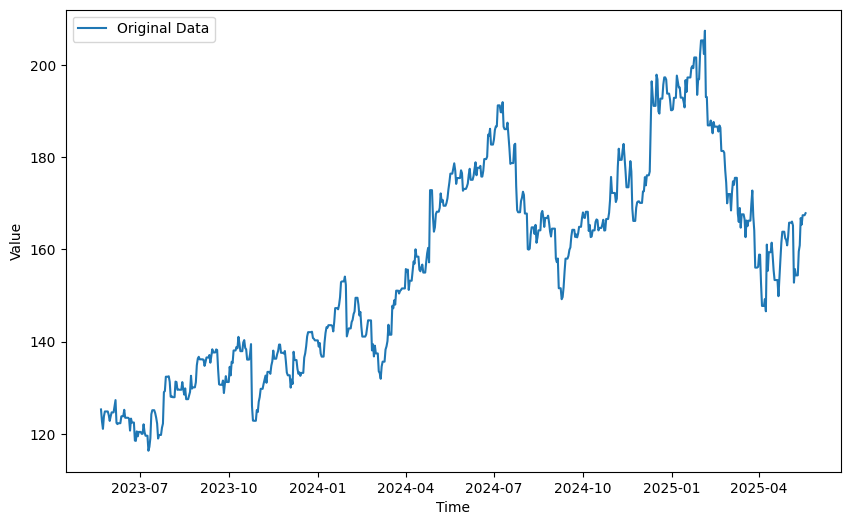

In [97]:
# Tạo khung hình biểu đồ với kích thước 10inch * 6inch
plt.figure(figsize=(10, 6)) 

# plt.plot: hàm vẽ dữ liệu đường
# ts.index: Trục hoành (x-axis), ts.values: Trục tung (y-axis)
plt.plot(ts.index, ts.values, label='Original Data')

# Hiển thị chú thích cho các đường đã vẽ (nhìn vào góc trên cùng bên phải là thấy)
plt.legend() 

# Gán nhãn cho trục hoành (x-axis) là Time
plt.xlabel('Time')

# Gán nhãn cho trục tung (y-axis) là Value
plt.ylabel('Value')

# hiện thị biểu đồ ra màn hình
plt.show() 

## 3.5. Chia tách dữ liệu thành tập huấn luyện và tập kiểm tra

In [98]:
# train/test split:chia tập dữ liệu thời gian thành tập huấn luyện và tập kiểm tra.
# tặp dữ liệu test: dùng để kiểm tra dự đoán đúng hay sai dựa vào so sánh đồ thị tập dữ liệu test và đồ thị dự đoán
# 0.8 là tỷ lệ dùng để chia dữ liệu ra: 80% dùng để huấn luyện (train), còn lại 20% để kiểm tra (test)
# trích ra 80% đầu tiên của ts – tức là tập huấn luyện (ts_train).
ts_train = ts.iloc[:int(ts.size * 0.8)] 

# trích ra 20% còn lại,tức là tập kiểm tra (ts_test).
ts_test = ts.iloc[int(ts.size * 0.8):] 

## 3.6. Trực quan hóa tập dữ liệu và tập kiểm tra trên đồ thị

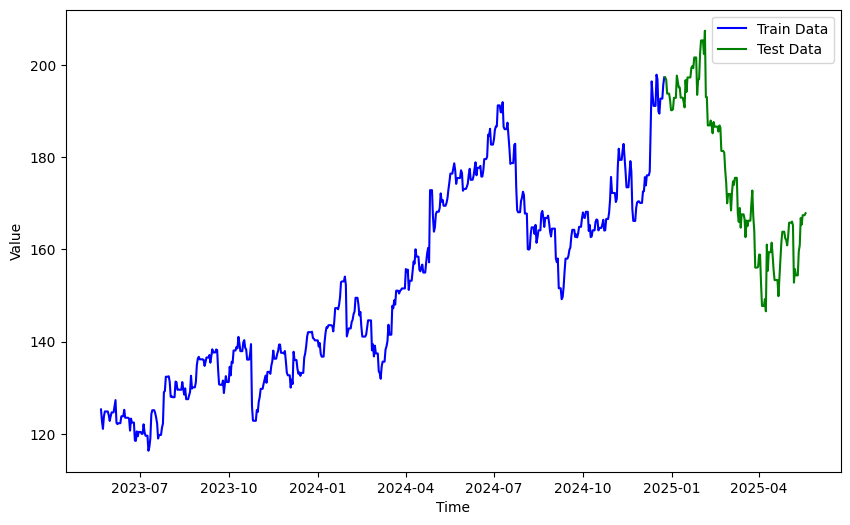

In [99]:
plt.figure(figsize=(10, 6))

# phân biệt tập dữ liệu train bằng màu xanh da trời, tập dữ liệu test bằng màu xanh lá cây
plt.plot(ts_train.index, ts_train.values, 'blue', label='Train Data')   # vẽ tập dữ liệu train màu xanh da trời
plt.plot(ts_test.index, ts_test.values, 'green', label='Test Data')     # vẽ tập dữ liệu test màu xanh lá cây

plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Bước 4: Định nghĩa mô hình LSTM cải tiến bằng GA

## 4.1. Định nghĩa mô hình LSTM

In [100]:
%%writefile simple_lstm.py
import numpy as np

class LSTM:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lr = learning_rate

        # Khởi tạo trọng số LSTM gates
        self.Wf = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wi = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wo = np.random.randn(hidden_size, hidden_size + input_size) * 0.1
        self.Wc = np.random.randn(hidden_size, hidden_size + input_size) * 0.1

        self.bf = np.zeros((hidden_size, 1))
        self.bi = np.zeros((hidden_size, 1))
        self.bo = np.zeros((hidden_size, 1))
        self.bc = np.zeros((hidden_size, 1))

        # Output layer
        self.Wy = np.random.randn(output_size, hidden_size) * 0.1
        self.by = np.zeros((output_size, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def dsigmoid(self, y):
        return y * (1 - y)

    def tanh(self, x):
        return np.tanh(x)

    def dtanh(self, y):
        return 1 - y**2

    def forward(self, inputs):
        self.seq_len = inputs.shape[0]
        self.h = np.zeros((self.seq_len + 1, self.hidden_size, 1))
        self.c = np.zeros((self.seq_len + 1, self.hidden_size, 1))

        self.f = np.zeros((self.seq_len, self.hidden_size, 1))
        self.i = np.zeros((self.seq_len, self.hidden_size, 1))
        self.o = np.zeros((self.seq_len, self.hidden_size, 1))
        self.c_bar = np.zeros((self.seq_len, self.hidden_size, 1))
        self.x = [inputs[t].reshape(-1, 1) for t in range(self.seq_len)]

        outputs = []

        for t in range(self.seq_len):
            combined = np.vstack((self.h[t], self.x[t]))

            self.f[t] = self.sigmoid(np.dot(self.Wf, combined) + self.bf)
            self.i[t] = self.sigmoid(np.dot(self.Wi, combined) + self.bi)
            self.o[t] = self.sigmoid(np.dot(self.Wo, combined) + self.bo)
            self.c_bar[t] = self.tanh(np.dot(self.Wc, combined) + self.bc)

            self.c[t+1] = self.f[t] * self.c[t] + self.i[t] * self.c_bar[t]
            self.h[t+1] = self.o[t] * self.tanh(self.c[t+1])

            y = np.dot(self.Wy, self.h[t+1]) + self.by
            outputs.append(y)

        self.outputs = outputs
        return np.array(outputs).squeeze()

    def backward(self, targets):
        # targets: (seq_len, output_size)
        dWf, dWi, dWo, dWc = [np.zeros_like(w) for w in (self.Wf, self.Wi, self.Wo, self.Wc)]
        dbf, dbi, dbo, dbc = [np.zeros_like(b) for b in (self.bf, self.bi, self.bo, self.bc)]
        dWy = np.zeros_like(self.Wy)
        dby = np.zeros_like(self.by)

        dh_next = np.zeros((self.hidden_size, 1))
        dc_next = np.zeros((self.hidden_size, 1))
        loss = 0

        for t in reversed(range(self.seq_len)):
            y_pred = self.outputs[t].reshape(-1, 1)
            y_true = targets[t].reshape(-1, 1)

            dy = y_pred - y_true
            loss += np.sum(dy**2)

            dWy += np.dot(dy, self.h[t+1].T)
            dby += dy

            dh = np.dot(self.Wy.T, dy) + dh_next
            do = dh * self.tanh(self.c[t+1]) * self.dsigmoid(self.o[t])
            dc = dh * self.o[t] * self.dtanh(self.tanh(self.c[t+1])) + dc_next
            di = dc * self.c_bar[t] * self.dsigmoid(self.i[t])
            df = dc * self.c[t] * self.dsigmoid(self.f[t])
            dc_bar = dc * self.i[t] * self.dtanh(self.c_bar[t])

            combined = np.vstack((self.h[t], self.x[t]))

            dWf += np.dot(df, combined.T)
            dbf += df
            dWi += np.dot(di, combined.T)
            dbi += di
            dWo += np.dot(do, combined.T)
            dbo += do
            dWc += np.dot(dc_bar, combined.T)
            dbc += dc_bar

            dcombined = (
                np.dot(self.Wf.T, df) +
                np.dot(self.Wi.T, di) +
                np.dot(self.Wo.T, do) +
                np.dot(self.Wc.T, dc_bar)
            )

            dh_next = dcombined[:self.hidden_size, :]
            dc_next = dc * self.f[t]

        # Gradient descent step
        for param, dparam in zip(
            [self.Wf, self.Wi, self.Wo, self.Wc, self.Wy, self.bf, self.bi, self.bo, self.bc, self.by],
            [dWf, dWi, dWo, dWc, dWy, dbf, dbi, dbo, dbc, dby]):
            param -= self.lr * dparam

        return loss / self.seq_len

    def train(self, X_train, y_train, epochs=50):
        for epoch in range(epochs):
            loss = 0
            for x, y in zip(X_train, y_train):
                self.forward(x)
                loss += self.backward(y)
            avg_loss = loss / len(X_train)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")


Overwriting simple_lstm.py


## 4.2. Định nghĩa giải thuật di truyền

In [101]:
%%writefile genetic_algorithm.py
import random
import numpy as np

class GeneticAlgorithm:
    """
    Thuật toán di truyền cơ bản để tối ưu hóa tham số.

    Tham số
    -------
    fitness_func : callable
        Hàm mục tiêu cần tối ưu (giá trị càng cao càng tốt nếu maximize=True).
    bounds : list of tuple
        Danh sách (min, max) cho mỗi tham số.
    population_size : int, optional
        Kích thước quần thể mỗi thế hệ (mặc định=20).
    generations : int, optional
        Số thế hệ (vòng lặp) cần chạy (mặc định=50).
    mutation_rate : float, optional
        Xác suất đột biến mỗi gene (mặc định=0.1).
    elitism : bool, optional
        Giữ lại cá thể tốt nhất qua thế hệ sau (mặc định=True).
    maximize : bool, optional
        Tối đa hóa (True) hay tối thiểu hóa (False) hàm mục tiêu (mặc định=True).
    """

    def __init__(self, fitness_func, bounds, population_size=20, generations=50,
                 mutation_rate=0.1, elitism=True, maximize=True):
        self.fitness_func = fitness_func
        self.bounds = bounds
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.elitism = elitism
        self.maximize = maximize

    def _initialize_population(self):
        # Khởi tạo ngẫu nhiên quần thể ban đầu trong khoảng ràng buộc
        return [
            [random.uniform(low, high) for (low, high) in self.bounds]
            for _ in range(self.population_size)
        ]

    def _evaluate_population(self, population):
        # Tính độ thích nghi của từng cá thể
        return [self.fitness_func(individual) for individual in population]

    def _select_parents(self, population, fitnesses, k=3):
        # Lựa chọn cha mẹ theo tournament selection
        parents = []
        for _ in range(self.population_size):
            aspirants = random.sample(list(zip(population, fitnesses)), k)
            winner = max(aspirants, key=lambda x: x[1])[0] if self.maximize else min(aspirants, key=lambda x: x[1])[0]
            parents.append(winner)
        return parents

    def _crossover(self, parent1, parent2):
        # Lai ghép hai cha mẹ tại điểm ngẫu nhiên
        point = random.randint(1, len(parent1) - 1)
        return parent1[:point] + parent2[point:]

    def _mutate(self, individual):
        # Đột biến từng gene với xác suất mutation_rate
        return [
            gene + random.uniform(-0.1, 0.1) if random.random() < self.mutation_rate else gene
            for gene in individual
        ]

    def run(self):
        """
        Chạy quá trình tối ưu bằng thuật toán di truyền.

        Trả về
        -------
        best_individual : list
            Bộ tham số tốt nhất tìm được.
        best_fitness : float
            Giá trị fitness tương ứng với cá thể tốt nhất.
        """
        population = self._initialize_population()
        best_individual = None
        best_fitness = -float('inf') if self.maximize else float('inf')

        for gen in range(self.generations):
            fitnesses = self._evaluate_population(population)
            current_best_idx = int(np.argmax(fitnesses)) if self.maximize else int(np.argmin(fitnesses))
            current_best = population[current_best_idx]
            current_best_fit = fitnesses[current_best_idx]

            if (self.maximize and current_best_fit > best_fitness) or \
               (not self.maximize and current_best_fit < best_fitness):
                best_individual = current_best
                best_fitness = current_best_fit

            print(f"Thế hệ {gen}: Fitness tốt nhất = {best_fitness:.5f}")

            parents = self._select_parents(population, fitnesses)
            next_population = []

            if self.elitism:
                next_population.append(best_individual)  # Giữ lại cá thể tốt nhất

            while len(next_population) < self.population_size:
                p1, p2 = random.sample(parents, 2)
                child = self._crossover(p1, p2)
                child = self._mutate(child)
                # Giới hạn giá trị gene trong khoảng ràng buộc
                child = [np.clip(g, *self.bounds[i]) for i, g in enumerate(child)]
                next_population.append(child)

            population = next_population

        return best_individual, best_fitness


Overwriting genetic_algorithm.py


# Bước 5: Huấn luyện mô hình

## 5.1. Định nghĩa phương thức create_sequence()

In [102]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Chuẩn hóa dữ liệu cho LSTM
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts)

# Cắt dữ liệu đã chuẩn hóa thành train/test
train_scaled = ts_scaled[:int(len(ts_scaled) * 0.8)]
test_scaled = ts_scaled[int(len(ts_scaled) * 0.8):]


## 5.2. Định nghĩa phương thức fitness_function()

In [103]:
from simple_lstm import LSTM  # File đã tạo

def fitness_function(params):
    window_size = int(round(params[0]))  # đảm bảo là int
    hidden_size = int(round(params[1]))  # đảm bảo là int

    X_train, y_train = create_sequences(train_scaled, window_size)
    X_train = [x.reshape(window_size, 1) for x in X_train]
    y_train = [y.reshape(1, 1) for y in y_train]

    model = LSTM(input_size=1, hidden_size=hidden_size, output_size=1, learning_rate=0.01)
    model.train(X_train, y_train, epochs=10)

    loss = 0
    for x, y in zip(X_train, y_train):
        pred = model.forward(x)
        loss += np.mean((pred[-1] - y.squeeze())**2)

    return -loss  # vì GA đang tối đa hóa



## 5.3. Lấy tham số window_size và hidden_size đã được tối ưu

In [104]:
from genetic_algorithm import GeneticAlgorithm  # File GA đã viết trước đó

# Giới hạn tham số: window size từ 5 đến 60, số neuron từ 1 đến 100
ga = GeneticAlgorithm(
    fitness_func=fitness_function,
    bounds=[(5, 30), (10, 100)],  # window_size, hidden_size
    population_size=10,
    generations=5,
    maximize=True
)

best_params, best_score = ga.run()
window_size = int(best_params[0])
hidden_size = int(best_params[1])
print(f"Tối ưu: window_size = {window_size}, hidden_size = {hidden_size}")


IndexError: index 22 is out of bounds for axis 0 with size 1

## 5.4. Huấn luyện mô hình bằng tham số tối ưu có được

In [ ]:
# Lấy params tốt nhất
window_size = int(best_params[0])
lstm_units = int(best_params[1])

# Chuẩn bị dữ liệu train + test để huấn luyện lại
series_all = ts.values.flatten()
X_all, y_all = create_dataset(series_all, window_size)
X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

# Huấn luyện LSTM lại với toàn bộ dữ liệu train + test để dự đoán
model = LSTM(input_size=1, hidden_size=lstm_units, output_size=1, learning_rate=0.01)
epochs = 30
for epoch in range(epochs):
    loss = 0
    for x, y in zip(X_all, y_all):
        model.forward(x)
        loss += model.backward(np.array([y]))
    loss /= len(X_all)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.5f}")

# Dự đoán giá trên tập test
X_test, y_test = create_dataset(ts_test.values.flatten(), window_size)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

y_pred = []
for x in X_test:
    pred = model.forward(x)
    y_pred.append(pred[-1])  # lấy giá trị output cuối cùng (dự đoán ngày tiếp theo)

y_pred = np.array(y_pred)


# Bước 6: Trực quan hóa kết quả dự đoán

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(ts_test.index[window_size:], y_test, label='Giá thực tế')
plt.plot(ts_test.index[window_size:], y_pred, label='Giá dự đoán LSTM+GA')
plt.title("So sánh Giá thực tế và Giá dự đoán trên tập Test")
plt.xlabel("Ngày")
plt.ylabel("Giá đóng cửa")
plt.legend()
plt.show()


In [ ]:
# Vẽ thêm đường dữ đoán vào đồ thị
plt.figure(figsize=(10, 6))
plt.plot(ts_train.index, ts_train.values, 'blue', label='Train Data')#vễ tập dữ liệu train màu xanh da trời
plt.plot(ts_test.index, ts_test.values, 'green', label='Test Data')#vẽ tập dữ liệu test màu xanh lá cây
plt.plot(ts_test.index, true_predictions, 'orange', label='Forecasted Data')#vẽ đường dữ liệu dự đoán màu cam
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [ ]:
# vẽ biểu đồ so sánh dữ liệu thực tế và dữ liệu dự đoán (vẽ riêng ra để thấy và phân tích)
plt.figure(figsize=(10, 6))
plt.plot(ts_test.index, ts_test.values, label='Original Data')#vẽ đồ thị test (chính là đường xanh lá cây đã thấy ở các đô thị trên)
plt.plot(ts_test.index, true_predictions, label='Forecasted Data')#vẽ đồ thị dự đoán(chính là đường màu cam đã thấy ở đồ thị trên )
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Forecast')#Gán tiêu đề cho biểu đồ là "ARIMA Forecast",mô tả đây là một biểu đồ thể hiện kết quả dự đoán bằng mô hình ARIMA=> sửa code chỗ này,thay thế ARIMA=LSTM+GA
plt.show()